当机器学习工具 **Scikit**-Learn 遇上了可视化工具 Mat**plot**lib，就衍生出 **Scikit-Plot**。 

Scikit-Plot 是由 Reiichiro Nakano 创建的用在机器学习的可视化工具。它简直就是玩机器学习的数据科学家的福音，能最快速简洁的画出用 Matplotlib 要写很多行语句才能画出的图。每个人都喜欢用一行代码 (one-liner) 完成任务。 


要使用 Scikit-Plot，首先要引用它并起个别名skplt。

In [11]:
import scikitplot as skplt

Scikit-Plot 有四大模块，**度量模块(Metrics Module)**、**估计器模块(Estimators Module)**、**聚类模块(Clusterer Module)**和**降维模块(Decomposition Module)**。

从 Scikit-Plot 官网中，搜集出这四大模块里所有的细分函数：

+ scikitplot.metrics
  + **plot_confusion_matrix：分类的混淆矩阵**
  + **plot_precision_recall：分类的查准查全**
  + **plot_roc：分类的 ROC 曲线**
  + plot_ks_statistic
  + **plot_silhouette：度量聚类好坏的轮廓系数**
  + plot_calibration_curve
  + plot_cumulative_gain
  + plot_lift_curve
+ scikitplot.estimators
  + **plot_learning_curve：学习曲线**
  + **plot_feature_importances：特征重要性**
+ scikitplot.cluster
  + **plot_elbow_curve：决定簇个数的肘部曲线**
+ scikitplot.decomposition
  + **plot_pca_component_variance：可解释方差**
  + **plot_pca_2d_projection：高维投影到二维**


加粗的函数是比较常见的，本帖用三个数据集来讲解它们，但不是单单讲解这些绘图函数，而花大量时间画大量图标来详细讲解相关的知识点，每个绘图函数和要明晰的知识点如下：

+ plot_pca_component_variance：主成分方差是什么？
+ plot_pca_2d_projection：为什么要降维？
+ plot_confusion_matrix：混淆矩阵是什么？
+ plot_precision_recall：查准率和查全率是什么？
+ plot_roc：ROC 和 AUC 是什么？
+ plot_silhouette：轮廓系数是什么？
+ plot_elbow_curve：肘部方法是什么？
+ plot_learning_curve：学习曲线是什么？
+ plot_feature_importances：特征重要性是什么？

此外，我们对比 Scikit-Plot 和 Matplotlib，思路就是用后者来复现前者绘制的图。前者只要一行代码，后者需要大量代码，通过对比，读者也会更加喜欢 Scikit-Plot 的便捷性。

# 1 手写数字数据集
## 1.1 数据介绍

### 手写数字数据集(MNIST)
MNIST 有 70000 张规格较小的手写数字图片，由美国的高中生和美国人口调查局的职员手写而成。每张图片有 784 个特征。这是因为每个图片都是 28*28 像素的，并且每个像素的值介于 0~255 之间。

下图以数字 8 举例，看看如何将一张图片转换成 784 个像素的。

<img style="float: mid;" src="images\40.jpg">

MNIST 的类别就 10 类，就是数字 0 到 9。

由于 MNIST 的数据集比较大，在 sklearn 中用 fetch_的方法，详细解释见〖机器学习之 Sklearn〗的小节 2.2 。再用 train_test_split 的方法将训练集和测试集分成 80:20 (test_size=0.2)。

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

seed = 1031

X,y = fetch_openml('mnist_784',version=1,return_X_y=True)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed)

print('The size of X_train is',X_train.shape)
print('The size of y_train is',y_train.shape)
print('The size of X_test is',X_test.shape)
print('The size of y_test is',y_test.shape)

The size of X_train is (56000, 784)
The size of y_train is (56000,)
The size of X_test is (14000, 784)
The size of y_test is (14000,)


70000 张的图片分成含 56000 张的训练集和含 14000 张的测试集，而且 X 有 784 个特征 (784 个像素)，X 和 y 的形状为

+ X = (样本数，特征数)
+ y = (样本数，)

照片像素在 0 到 255 之间，做正规化 (除以 255) 使得 X_train 和 X_test 里的元素在 0 和 1 之间。

In [13]:
X_train,X_test = X_train/255.0,X_test/255.0

取y里不重复的类别个数，10类，分别是数字0，1，2，...，9.

In [14]:
import numpy as np 

n_class = len(np.unique(y))
n_class

10

看看训练集中前 100 张图片和对应的标签 (左下角蓝色小字)。

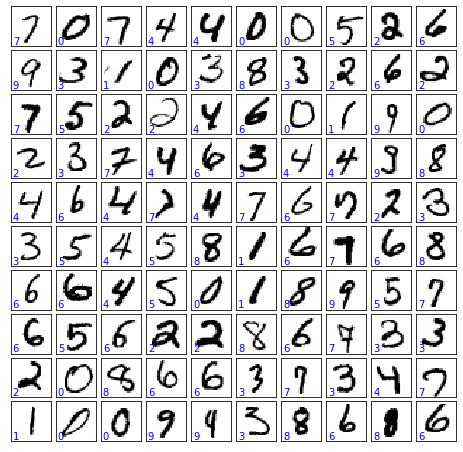

In [15]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(10,10,figsize=(8,8))
fig.subplots_adjust(hspace=0.1,wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28,28),cmap='binary',interpolation='nearest')
    ax.text(0.05,0.05,str(y_train[i]),transform=ax.transAxes,color='blue')
    ax.set_xticks([])
    ax.set_yticks([])

在下面五节我们来多分类 0 到 9 这十个数字。由于 784 个特征太多，首先我们想用「主成分分析」做特征降维，并投影在二维平面可视化数据，之后再用「对率回归」来分类，并画出相应的混淆矩阵、查准率查全率，接受者操作特征曲线等指标。

## 1.2 可解释方差

Scikit-Plot 中的 plot_pca_component_variance 函数可以画出「主成分分析」里「主成分个数-解释方差比率」一一对应的关系图。

先看一个「主成分分析」的知识点。

### 主成分分析
主成分分析 (Principle Component Analysis, PCA) 是一种分析、简化数据集的技术。

PCA 经常用于减少数据集的维数，同时保持数据集中的对方差贡献最大的特征。

关于方差的直观解释如下图，深青点是数据，红色轴和灰色轴可想象成两个超平面，红点和灰点则是数据在超平面上的投影。那么方差是衡量投影数据的分散程度。

<img style="float: mid;" src="images\41.jpg">

显然把数据投影在红色轴上 (大方差) 以后更容易分类。因此 PCA 做的事情就是让样本点在某个超平面上的投影能尽可能地分开，即需最大化投影点的方差。

我们总听到有人说「前 3 个主成分解释了 75% 的总方差」，这到底是什么意思呢？首先 PCA 每个主成分 PC 都可以解释数据中一部分方差，排序图如下，方差率越高，说明越是重要的 PC。

<img style="float: mid;" src="images\42.jpg">

总方差等于每一个 PC 的方差之和，而 PC i 可解释的方差比率等于

方差比率 i = 方差 i /总方差

具体来讲

+ 第一个 PC 解释了 35% 的总方差
+ 前两个 PC 解释了 48% 的总方差
+  ...
+ 前十个 PC 解释了 98% 的总方差
+ 所有 PC 解释了 100% 的总方差

显然，用到的 PC 越多，解释了方差比率也就越高。一般来说，我们都先定一个「可解释方差」的阈值 (threshold)，然后找出对应的 PC 的个数。用上图的例子，我们希望 80% 的方差能被解释，因此选前 6 个 PC。

首先创建PCA估计器命名为pca，再拟合训练集X_train。

In [16]:
from sklearn.decomposition import PCA

pca = PCA(random_state=seed) #seed = 1031
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1031,
    svd_solver='auto', tol=0.0, whiten=False)

函数 plot_pca_component_variance 用到的参数有 3 个：

+ pca：PCA 估计器
+ target_explained_variance：可解释方差的比率
+ figsize：图片大小

<function matplotlib.pyplot.show(*args, **kw)>

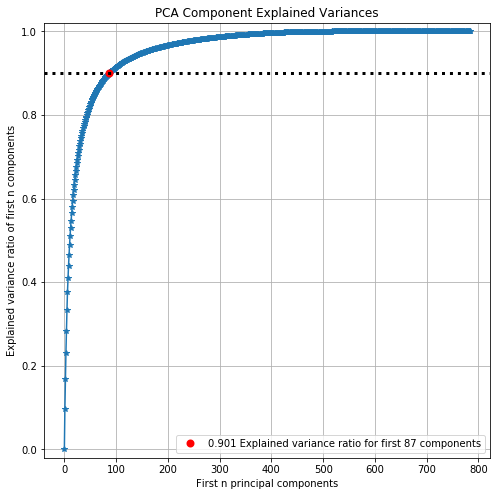

In [17]:
import matplotlib.pyplot as plt 
import scikitplot as skplt 

skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.90,figsize=(8,8))
plt.show

上图展示了两条信息：

蓝色曲线 - PC 个数和可解释方差比率呈递增关系，而且一开始猛增，后来微增。前 100 个 PC 大概可以解释 90% 的方差了，而后面 684 个 PC (一张总共 784 个特征) 才解释 10% 的方差。如果想压缩数据，可以不要后面 684 个 PC，压缩率 87.2% (684/784)。

红色点 - 目标可解释方差比率和对应的 PC 个数，在本例中分别是 90% 和 87。


## 1.3 降维投影

Scikit-Plot 中的 plot_pca_2d_projection 函数可以画出用 PCA 将「高维数据」投影到「二维平面」，便于我们可视化不同类别的在二维平面上特征表示。

先看一个「PCA 降维」的知识点。

### PCA 降维

PCA 将 n 个特征降维到 k 个，可以用来进行数据压缩，例如 784 维的向量最后可以用二维来表示，那么压缩率为 99.7% (1-(2/784))。

降到二维是为了可视化，三维以上的东西很难想像。

首先创建PCA估计器命名为pca，再拟合训练集X_train

In [18]:
from sklearn.decomposition import PCA

pca = PCA(random_state=seed)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1031,
    svd_solver='auto', tol=0.0, whiten=False)

函数 plot_pca_component_variance 用到的参数有 4 个：

+ pca：PCA 估计器
+ X_train：训练集特征
+ y_train：训练集标签
+ figsize：图片大小

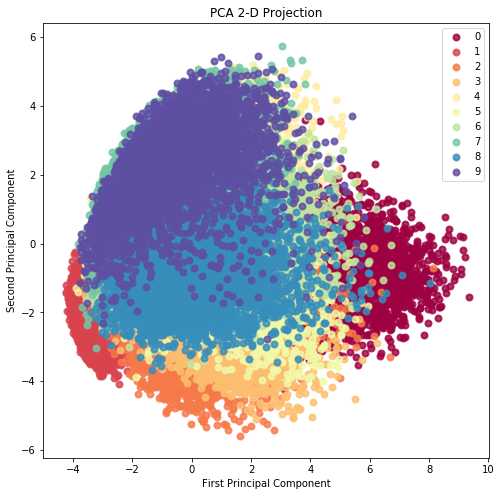

In [19]:
skplt.decomposition.plot_pca_2d_projection(pca,X_train,y_train,figsize=(8,8))
plt.show()

上图中每一种颜色代表一个数字，图的右上角也有相应的标识。虽然从 784 维度降到 2 维，但是从图上看这十个数字还是大致能被分开的，这给之后的分类也带来了信心。

## 1.4 混淆矩阵

Scikit-Plot 中的 plot_confusion_matrix 函数可以画出分类问题后的混淆矩阵，该矩阵的行和列代表预测结果和实际标签，是评估分类器好坏的一个可视化工具。

先看一个「混淆矩阵」的知识点。

### 混淆矩阵
在分类任务中，模型预测和标签总不是完全匹配，而混淆矩阵 (confusion matrix) 就是记录模型表现的 N×N 表格 (其中 N 为类别的数量)，通常一个轴列出真实类别，另一个轴列出预测类别。

对于二分类问题，可将样例根据其真实类别与模型预测类别的组合划分为真正类 (true positive, TP)，真负类 (true negative, TN)，假正类 (false positive, FP) 和假负类 (false negative, FN)。

+ 预测类别的真假来描述“正类负类”，预测为真 = 正类，预测为假 = 负类。
+ 真实类别和预测类别的同异来描述“真假”，相同= 真，不同 = 假。
+ 真正类 = 预测类别为真且和真实类别相同，真负类 = 预测类别为假且和真实类别相同。
+ 假正类 = 预测类别为真但和真实类别不同，假负类 = 预测类别为假和真实类别不同。

以二分类任务 (识别一个数字是5还是非 5) 为例 N = 2 的混淆矩阵的一般形式和具体例子如下：

<img style="float: mid;" src="images\43.jpg">


看右图：

+ 真负类：8, 3, 9, 7, 2 - 都是非 5 的数字 (负类)，而且也分类正确。
+ 假正类：6 - 是非 5 的数字 (正类)，但误以为是 5 而分类错误。
+ 假负类：2 个难辨认的 5 - 是数字 5 (负类)，但没认出来是 5 而分类错误。
+ 真正类：3 个正常的 5 - 是数字 5 (正类)，而且也分类正确。

正规化 (normalized) 的混淆矩阵显示的不是 TP, FN, FP, TN 的个数，而是它们的百分比，转换过程如下

+ TP→TP/(TP+FN)
+ FN→FN/(TP+FN)
+ FP→FP/(FP+TN)
+ TN→TN/(FP+TN)

二分类的混淆矩阵弄懂了，多分类的混淆矩阵类比如下。

<img style="float: mid;" src="images\44.jpg">

为了打印出混淆矩阵，我们首先运行「对率回归」LogisticRegression 模型 (用 L1 做正则化，n_jobs 设置 -1 为了利用所有的内存)，在训练集 (X_train, y_train) 上做拟合。

In [20]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(penalty='l1',solver='saga',multi_class='multinomial',n_jobs=-1)
LR.fit(X_train,y_train)

D:\MyApps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

显示训练精度 (1 - 训练误差) 和测试精度 (1 - 测试误差)，分别为 93.8% 和 92.3%，对于一个没调参的对率回归模型结果已经很不错了。

In [21]:
from sklearn.metrics import accuracy_score

y_pred = LR.predict(X_test)

print('Train accuracy = ' + '{0:6.4}'.format(accuracy_score(y_train,LR.predict(X_train))))
print('Test accuracy = ' + '{0:6.4}'.format(accuracy_score(y_test,y_pred)))

Train accuracy = 0.9373
Test accuracy = 0.9234


函数 plot_confusion_matrix 用到的参数有 4 个：

+ y_test：测试集真实标签
+ y_pred：测试集预测标签
+ normalize：将个数转成百分比
+ figsize：图片大小


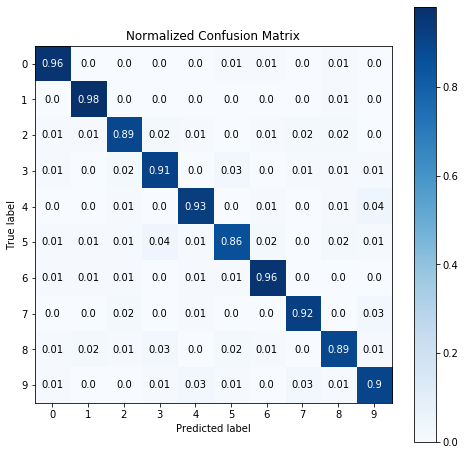

In [22]:
import matplotlib.pyplot as plt 
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(y_test,y_pred,normalize=True,figsize=(8,8))
plt.show()

上图展示了两条信息：

1. 矩阵里面的数字 - 第 i 行第 j 列的数字代表「预测为类 j 但真实为类 i 的比例」，显然我们希望 (i, i) 上的数字越大越好，其他位置上的数字越小越好。从上面结果可知分类器的准确率还不错。

2. 色彩条 - 对角线上颜色越深正确率越高，非对角线上颜色越浅正确率越高。

## 1.5 查准率查全率

Scikit-Plot 中的 plot_precision_recall 函数可以画出分类问题后预测每个类别的「查准率」和「查全率」一一对应的关系图。

先看「查准率和查全率」和「查准查全曲线」两个知识点。

### 查准率和查全率
混淆矩阵里面的数字代表的是准确率 (accuracy)，即「相应分类正确的样本数」占「该类的样本总数」的比例。

准确率虽然常用，但是不能满足所有任务需求。比如下表列出勒布朗詹姆斯在某四场中的个人数据和骑士输赢情况。

<img style="float: mid;" src="images\45.jpg">

假定用训练好的模型预测骑士赢球，显然，准确率衡量了多少比赛实际是赢球而且预测对了。但是若我们关心的是“预测出的比赛中有多少场是赢球”，或“赢球的比赛中有多少场被预测出了”，那么准确率这个单一指标显然就不够用了，这时需要引进更为细分的性能度量，即查准率 (precision) 和查全率 (recall)。下面一图可以秒懂两者。

<img style="float: mid;" src="images\46.jpg">

在上图中

+ 有用的东西 = 所有真实的正类
+ 挑选的东西 = 所有预测的正类

<img style="float: mid;" src="images\47.jpg">

### 查准查全曲线
查准查全曲线指的 Precision-Recall 曲线，简称 PR 曲线。它是根据不同决策阈值 (decision threshold) 得到不同的查全率 R 和查准率 P，再以 R 为横坐标，P 为纵坐标，画出一条曲线。

那二分类问题具体来说，在最终分类时，我们会得到两个概率式的结果，如

+ P(正类) = 0.8
+ P(负类) = 0.2

通常我们会分成正类，那是因为我们设定了一个 0.5 的决策阈值，P(正类) 大于它就是正类，小于它就是负类。如果阈值是 0.6, 0.7 呢？结果还是一样。如果阈值是 0.9 呢？那么就应该分成负类了。

说了这么多就是强调阈值可以改变预测正类的负类的标准及个数，也改变了查准率和查全率 (看上个知识点的公式)。一般来说，阈值越高

+ 越不容易预测出正类，查全率下降 (和阈值成递减关系)
+ 预测的正类几乎对的，查准率上升 (和阈值成递增关系)

阈值越低

+ 非常容易预测出正类，查全率上升 (和阈值成递减关系)
+ 预测的正类几乎错的，查准率下降 (和阈值成递增关系)

因此查准率和查全率互为冲突，

+ 查准率高时，查全率往往低。
+ 查全率高时，查准率往往低。

如下图所示，模型 A 对应的查全查准曲线完全在模型 B 对应的曲线之上，因此模型 A 好过模型 B。理想模型的曲线是图中的 (1,1) 那个点，查准率和查全率都是100%。

<img style="float: mid;" src="images\48.jpg">

那么 PR 曲线下的面积怎么计算呢？解释如图。

<img style="float: mid;" src="images\49.jpg">

给定 6 个阈值 c0 =1, c1, c2, c3, c4, c5 = 0，分类计算出 6 个

+ 查准率：P0, P1, P2, P3, P4, P5
+ 查全率：R0, R1, R2, R3, R4, R5

再计算五个矩形面积 Si 最后加总，阈值划分的越细，曲线越平滑，计算的面积值也越精确。

严谨的公式如下

<img style="float: mid;" src="images\50.jpg">

面积越接近1，分类的效果越好。

函数 plot_precision_recall 用到的参数有 3 个：

+ y_test：测试集真实标签
+ y_prob：测试集预测标签的概率
+ figsize：图片大小

首先用 predict_proba 得到 y_prob，再画出查准查全曲线 (PR 曲线)

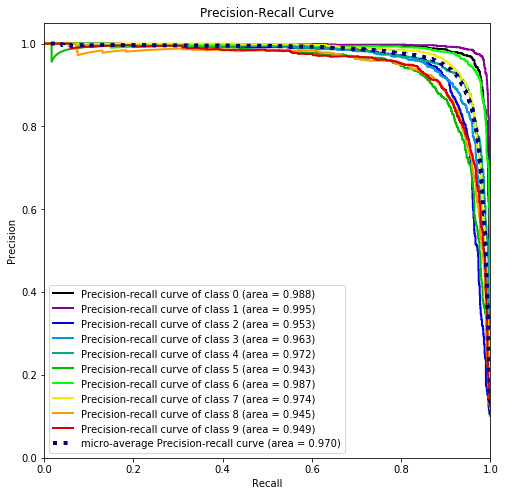

In [23]:
y_prob = LR.predict_proba(X_test)

skplt.metrics.plot_precision_recall(y_test,y_prob,figsize=(8,8))
plt.show()

上图展示了两条信息：

+ 10 条实线 - 10 个类别的「PR 曲线」以及曲线下的面积。面积都很接近 1，每类的查准率和查全率都还不错。

+ 1 条虚线 -  考虑全部类别的「微观平均PR 曲线」以及曲线下的面积。面积为0.97，整体的查准率和查全率也还不错。


## 1.6 接受者操作特征曲线

Scikit-Plot 中的 plot_roc 函数可以画出用分类问题后每个类别的「接受者操作特征曲线 ROC」和「曲线下面积 AUC」一一对应的关系图。

先看一个「接受者操作特征曲线」的知识点。

### 接受者操作特征曲线
ROC 是 receiver operating characteristic 的简称，直译为「接受者操作特征」。「ROC 曲线」非常类似「PR 曲线」，但图的横轴纵轴并不是查准率和查全率。「ROC 曲线」反映在不同分类阈值上，真正类率 (true positive rate, TPR) 和假正类率 (false positive rate, FPR) 的关系。

+ TPR 是「真正类」和所有正类 (真正类+假负类) 的比率，真正类率 = 查全率
+ FPR 是「假正类」和所有负类 (假正类+真负类) 的比率，假正类率 = 1- 真负类率 = 1 - 特异率 (specificity)

一般来说，阈值越高

+ 越不容易预测出正类，TPR 下降 ( TPR 和阈值成递减关系)
+ 越容易预测出负类，(1- FPR) 上升 ( FPR 和阈值成递减关系)

阈值越低

+ 越容易预测出正类，TPR 上升 ( TPR 和阈值成递减关系)
+ 越不容易预测出负类，(1- FPR) 下降 ( FPR 和阈值成递减关系)

因此 TPR 和 FPR 是单调递增关系。

「PR 曲线」和「ROC 曲线」对比图见下，后者和横轴之间的面积叫AUC，是 area under the curve 的简称。

<img style="float: mid;" src="images\51.jpg">

AUC 将所有可能分类阈值的评估标准浓缩成一个数值，根据 AUC 大小，我们得出

<img style="float: mid;" src="images\52.png">


如何计算 AUC 和计算 PR 曲线下的面积一样的，把横坐标和纵坐标代表的变量弄对就可以了，如下图。

<img style = 'float:mid;' src = 'images\53.jpg'>

如何确定这些 $ TPR_i $ 和 $ FPR_i $ (i = 0,1,...,5) 不是一件容易讲清的事，我试试，先看一个二分类预测类别以及预测正类概率的表 (按照预测概率降序排序，其中正类 P 和负类 N 都有 10 个)。

<img style='float:mid' src='images\54.jpg'>

**第一个点**：当阈值 = 0.9，那么第 1 个样本预测为 P，后 19 个样本预测为 N，这时

+ TPR = 真正类/全部正类 = 1/10 =0.1 
+ FPR = 1 - 真负类/全部负类 = 1 - 10/10 =0 
+ 阈值 0.9 → (0, 0.1)

**第二个点**：当阈值 = 0.8，那么第 1, 2 个样本预测为 P，后 18 个样本预测为 N，这时

+ TPR = 真正类/全部正类 = 2/10 =0.2 
+ FPR = 1 - 真负类/全部负类 = 1 - 10/10 =0 
+ 阈值 0.8 → (0, 0.2)
...

**第四个点**：当阈值 = 0.6，那么前 4 个样本预测为 P，后 16 个样本预测为 N，这时

+ TPR = 真正类/全部正类 = 3/10 =0.3 
+ FPR = 1 - 真负类/全部负类 = 1 - 9/10 =0.1 
+ 阈值 0.8 → (0.1, 0.3)

...

**最后一个点**：当阈值 = 0.1，那么全部样本预测为 P，零样本预测为 N，这时

+ TPR = 真正类/全部正类 = 10/10 =1 
+ FPR = 1 - 真负类/全部负类 = 1 - 0/10 =1 
+ 阈值 0.8 → (1, 1)

因此可画出下图右半部分，即 ROC 曲线，再根据横坐标纵坐标上的 FPR 和 TPR 计算 AUC。AUC越大，分类器的质量越好。

<img style = 'float:mid' src  ='images\55.jpg'>


函数 plot_roc 用到的参数有 3 个：

+ y_test：测试集真实标签
+ y_prob：测试集预测标签的概率
+ figsize：图片大小

首先用 predict_proba 得到 y_prob，再画出 ROC 曲线。

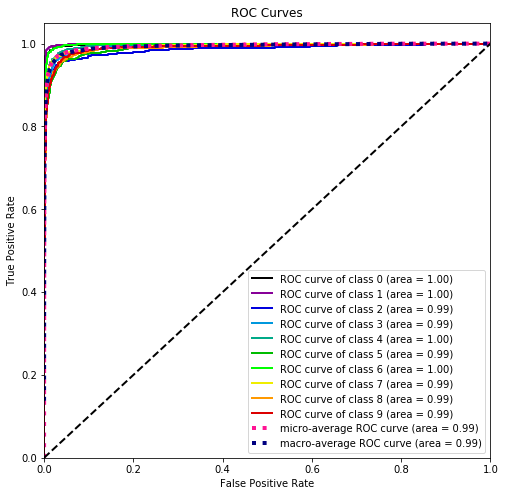

In [24]:
y_prob = LR.predict_proba(X_test)

skplt.metrics.plot_roc(y_test,y_prob,figsize=(8,8))
plt.show()

上图展示了三条信息：

+ 10 条实线 - 10 个类别的「ROC 曲线」和 AUC (几乎为 1)。

+ 1 条桃红虚线 - 考虑全部类别的「微观平均 ROC 曲线」和 AUC (0.99)，整体的查准率和查全率也还不错。

+ 1 条深蓝虚线 - 给每个类别相同权重的「宏观平均 ROC 曲线」和 AUC (0.99)。


PR 曲线和 ROC 曲线应用范围如下：

1. 当正负样本比例差不多的时候，两者区别不大。
2. PR 曲线比 ROC 曲线更加关注正样本，而 ROC 则兼顾了两者。
3. AUC越大，反映出正样本的预测结果更加靠前。
4. 当正负样本比例失调时，如正样本 1 个，负样本100个，则 ROC 曲线变化不大，此时用 PR 曲线更加能反映出分类器性能的好坏。

## 数据降维+对率回归

从混淆矩阵、PR 曲线、ROC 曲线和 AUC 指标可以看出一个简单的对率回归模型在 MNIST 分类任务表现还不错，但是训练时间有点长，56000 的样本数加上 784 的特征数。

其实从「可解释方差」那图也可以看出，有近 700 个主成分只能解释 10% 的方差，因此我们可以去掉它们来压缩数据。假设我们目标是解释 75% 的方差，用函数 plot_pca_component_variance 画图发现保留前 33 个主成分即可。


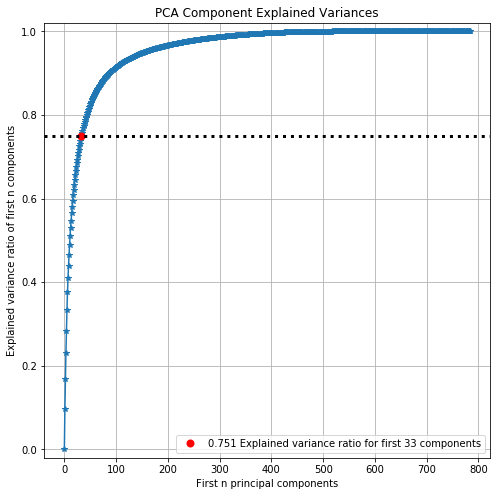

In [25]:
skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.75,figsize=(8,8))
plt.show()

还是用 LogisticRegression 来做分类，只不过一开始用 PCA 只保留前 33 个主成分。这时训练数据 X_train_rd 是 X_train 压缩过的 (rd 后缀表示 reduced.)，把这个模型命名为 LR_rd。

In [26]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=33,random_state=seed)
pca.fit(X_train)
X_train_rd = pca.transform(X_train)
X_test_rd = pca.transform(X_test)

LR_rd = LogisticRegression(penalty='l1',solver='saga',multi_class='multinomial',n_jobs=-1)
LR_rd.fit(X_train_rd,y_train)

D:\MyApps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

用这个压缩模型生成的训练准确率和测试准确率也没有降多少，大概是从 93% 到 90% 的降幅，但是训练时间快了 10 倍不止。

In [27]:
from sklearn.metrics import accuracy_score

y_pred = LR_rd.predict(X_test_rd)

print('Train accuracy = ' + '{0:6.4}'.format(accuracy_score(y_train,LR_rd.predict(X_train_rd))))
print('Test accuracy = ' + '{0:6.4}'.format(accuracy_score(y_test,y_pred)))

Train accuracy = 0.8977
Test accuracy = 0.8988


对比一下完整模型 LR 和压缩模型 LR_rd 的混淆矩阵、PR 曲线和 ROC 曲线，性能都只稍稍差了一点，因此我们为了大大提高运行效率，可以只保留 784 个主成分中的 33 个。

<img style = 'float:mid' src = 'images\56.jpg'>

<img style = 'float:mid' src = 'images\57.jpg'>

<img style = 'float:mid' src = 'images\58.jpg'>

# 2 鸢尾花数据集

## 2.1 数据介绍

本小节使用的数据是

鸢尾花数据集 (Iris Flower)

Iris 以鸢尾花的特征作为数据来源，它是一个多元分类问题，一共有 150 个样例。该数据集包含了 4 个特征和 1 个类变量：

+ 花萼长度 (sepal length)
+ 花萼宽度 (sepal width)
+ 花瓣长度 (petal length)
+ 花瓣宽度 (petal width)
类变量：Iris Setosa (山鸢尾), Iris Versicolour (杂色鸢尾), Iris Virginica (维吉尼亚鸢尾)

三种鸢尾花的图片如下：

<img style = 'float:mid' src = 'images\59.jpg'>

花萼和花瓣的标识如下：

<img style = 'float:mid' src = 'images\60.jpg'>

鸢尾花的数据集很小，在 sklearn 中用 load_ 的方法，详细解释见〖机器学习之 Sklearn〗的小节 2.2 。在用 train_test_split 的方法将训练集和测试集分成 80:20 (test_size=0.2)。

In [28]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

X_train,X_test,y_train,y_test = train_test_split(iris['data'],iris['target'],test_size=0.2,random_state=seed)

print('The size of X_train is',X_train.shape)
print('The size of y_train is',y_train.shape)
print('The size of X_test is',X_test.shape)
print('The size of y_test is',y_test.shape)

The size of X_train is (120, 4)
The size of y_train is (120,)
The size of X_test is (30, 4)
The size of y_test is (30,)


150 个样例分成含 120 个的训练集和含 30 个的测试集，而且 X 有 4 个特征 (花萼长、花萼宽、花瓣长、花瓣宽)，X 和 y 的形状为

+ X = (样本数，特征数)
+ y = (样本数，)

在下两节我们用该数据来聚类 (不是分类)，因此用不到标签 y。

## 2.2 轮廓系数

Scikit-Plot 中的 plot_silhouette 函数可以画出聚类问题后每个簇的「轮廓系数」来评价聚类效果好坏。

先看一个「轮廓系数」的知识点。

### 轮廓系数
轮廓方法 (silhouette method) 会评估聚类的质量，会衡量

+ 对象和所属簇之间的相似度，即内聚性 (cohesion)
+ 对象和其他簇之间的相离度，即分离性 (separation)

这个评估指标叫做轮廓系数 (silhouette coefficient)，定义为 S(i)，其中 i 代表第 i 个样本。再定义

+ a(i) 代表样本 i 到同簇其他样本的平均距离，a(i) 越小说明该样本越应该被聚类到该簇，a(i) 也称为样本 i 的簇内不相似度。

+ b(i) 代表样本 i 到异簇其他样本的平均距离的最小值，b(i) 越大说明该样本越不属于其他簇，b(i) 也称为样本 i 的簇间不相似度。

根据样本 i 的 簇内不相似度a(i) 和 簇间不相似度b(i)，给出轮廓系数 S(i) 的公式

<img style = 'float:mid' src = 'images\61.jpg'>

对a(i)和b(i)的可视化如下

<img style = 'float:mid' src = 'images\62.jpg'>

从公式不难看出 S(i) 是在 \[-1, 1] 范围内，继续分析

+ s(i) 接近 1，即 b(i) 远大于a(i)，则说明样本 i 聚类合理
+ s(i) 接近 -1，即 b(i) 远小于a(i)，则说明样本 i 更应该划分到另外的簇
+ 若 s(i) 近似为 0，则说明样本 i 在两个簇的边界上

所有样本的 S(i) 的均值称为聚类结果的轮廓系数，是该聚类是否合理、有效的度量。

首先创建 KMeans 估计器命名为 KM，簇个数 n_clusters 设置为 3 (其实我们事先直到鸢尾花有三类，通常是给定不同的 n_clusters)，打印出聚类的标签。

In [29]:
from sklearn.cluster import KMeans
seed = 1031 
KM = KMeans(n_clusters=3,random_state=seed)
cluster_labels = KM.fit_predict(X_train)
print(cluster_labels)

[0 1 0 2 0 1 1 0 0 1 1 1 1 1 2 1 1 1 1 1 1 0 1 1 0 1 2 0 0 1 2 0 2 0 2 0 0
 1 0 2 2 2 1 1 0 1 2 1 1 1 2 1 0 2 2 2 1 2 0 0 2 1 1 2 1 0 2 1 0 2 1 2 1 0
 0 1 1 0 2 0 0 1 1 0 1 1 2 1 1 2 2 2 1 2 2 0 2 0 1 1 0 2 1 0 0 0 1 0 1 2 0
 2 0 0 1 0 1 0 1 1]


120 个训练集X_train 被聚成三类，类 0，类 1 和类 2。

函数 plot_silhouette 用到的参数有 3 个：

+ X_train：训练集特征
+ cluster_labels：聚类标签
+ figsize：图片大小


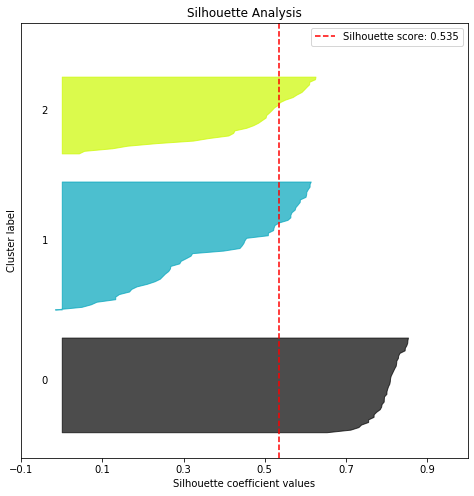

In [30]:
import scikitplot as skplt 
import matplotlib.pyplot as plt 

skplt.metrics.plot_silhouette(X_train,cluster_labels,figsize=(8,8))
plt.show()

上图展示了两条信息：

+ 红色虚线- 总平均轮廓系数 0.535。

+ 3 坨阴影- 在每个类里都画出轮廓系数 S(i) 的分布图。类 0 的效果非常好，基本上每个样本的 S(i) 都远远超过 0.535。

再看看 n 设成 4 的情况？

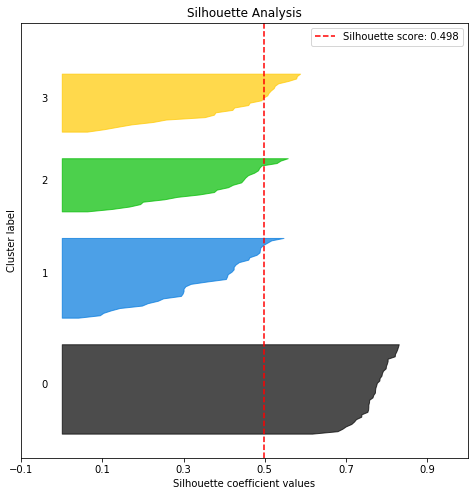

In [31]:
skplt.metrics.plot_silhouette(X_train,KMeans(n_clusters=4,random_state=seed).fit_predict(X_train),figsize=(8,8))
plt.show()

总平均轮廓系数降低了，从 0.535 到 0.498，即聚类质量下降了。本来嘛，这个鸢尾花就只有三类，你说你弄个四类当然不好了。但是在没有标签的时候呢？你还是要试试各种可能性啊。

## 2.3 肘部曲线

Scikit-Plot 中的 plot_elbow_curve 函数可以画出聚类分类后「簇的个数」和「损失函数」的一一对应的关系图。

先看一个「肘部法则」的知识点。

### 肘部法则
在聚类没有标记的数据时，通常我们是不知道簇的个数的。具体到 K-mean 方法而言，我们是不知道 K 的大小的。

Kmean 的算法就是最小化「每个簇的所有点和对应的簇心」的距离平方和，定义为 J(c, μ)，其中 c 代表类别，代表 μ 簇心。

<img style = 'float;mid' src = 'images\63.jpg'>

不难推出，K 和 J 是单调递减关系。想个极端情况，当 K 等于数据总数 m 时，那么每个点都被聚成一类，每个点都是簇心，那么 J = 0。那么如何选一个最好的 K 呢？分三步：

1. 画出 K 和 J 的函数图
2. 确定肘部，即曲线畸变程度的改善效果下降幅度最大的位置
3. 将该位置对应 K 作为最佳值

如下图所示 (红圈标注的肘部)

<img style = 'float;mid' src = 'images\64.jpg'>

肘部对应的最优值 K = 2

+ 在 K < 2 时，J 下降快
+ 在 K > 2 时，J 下降慢，增加 K 值获益也不大

函数 plot_elbow_curve 用到的参数有 4 个：

+ KM：K-mean 估计器
+ X_train：训练集特征
+ cluster_ranges：簇个数从 1 到 29
+ figsize：图片大小

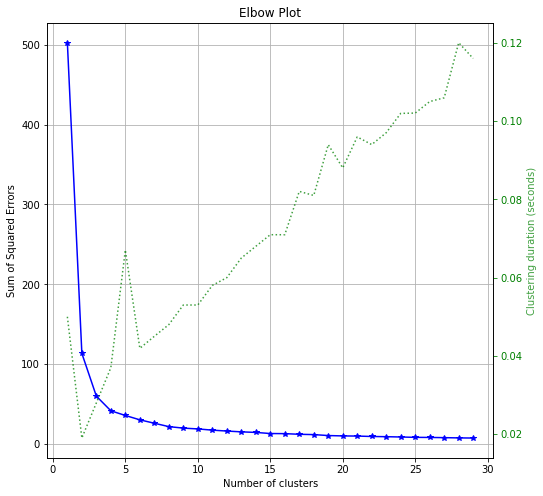

In [32]:
skplt.cluster.plot_elbow_curve(KM,X_train,cluster_ranges=range(1,30),figsize=(8,8))
plt.show()

上图展示了两条信息 (注意有两个 y 轴)：

1. 蓝色实线 - 损失函数 (sum of square errors) 随着 K 递减，肘部对应的 K = 3 或者 4。回想鸢尾花数据是有 3 类，但如果事先不知道标签呢？是否聚成 4 类也是合理呢？这个在实际的「无监督学习」中对 3 和 4 类可以都试试，看看聚类后用在「有监督学习」的分类问题上哪个更好。其实从上图来看，K = 4 更像肘部。

2. 绿色虚线 - 运行时间随着 K 基本递增，这个也合理，要聚的簇越多，也越耗时。


# 3 乳腺癌数据集

## 3.1 数据介绍

本小节使用的数据是
### 乳腺癌数据集 (Breast Cancer)

该数据集可用于进行患者乳腺癌治疗结果预测。它是一个二元分类问题，一共有 569 个样例。该数据集包含了 30 个特征和 1 个类变量：

1. mean radius
2. mean texture
3. mean perimeter
4. mean area
5. mean smoothness
6. mean compactness
7. mean concavity
8. mean concave points
9. mean symmetry
10. mean fractal dimension
11. radius error
12. texture error
13. perimeter error
14. area error
15. smoothness error
16. compactness error
17. concavity error
18. concave points error
19. symmetry error
20. fractal dimension error
21. worst radius
22. worst texture
23. worst perimeter
24. worst area
25. worst smoothness
26. worst compactness
27. worst concavity
29. worst concave points
29. worst symmetry
30. worst fractal dimension
31. 类变量：M = 恶性肿瘤，B =良性肿瘤

乳腺癌的数据集不大，在 sklearn 中用 load_ 的方法，详细解释见〖机器学习之 Sklearn〗的小节 2.2 。在用 train_test_split 的方法将训练集和测试集分成 80:20 (test_size=0.2)。

In [33]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

seed = 1031
breast_cancer = load_breast_cancer()

X_train,X_test,y_train,y_test = train_test_split(breast_cancer['data'],breast_cancer['target'],test_size=0.2,random_state=seed)

print('The size of X_train is',X_train.shape)
print('The size of y_train is',y_train.shape)
print('The size of X_test is',X_test.shape)
print('The size of y_test is',y_test.shape)

The size of X_train is (455, 30)
The size of y_train is (455,)
The size of X_test is (114, 30)
The size of y_test is (114,)


569 个样例分成含 455 个的训练集和含 114 个的测试集，而且 X 有 30 个特征，X 和 y 的形状为

+ X = (样本数，特征数)
+ y = (样本数，)

## 3.2 学习曲线

Scikit-Plot 中的 plot_learning_curve 函数可以画出在不同训练样本下的「训练精度」和「交叉验证精度」的线状图，即所谓的「学习曲线」。

先看一个「学习曲线」的知识点。

### 学习曲线
学习曲线是将训练误差和验证误差作为训练数据数量的函数绘制的图表。直观来讲，随着训练数据的数量的增加

+ 验证误差会越来越小，数据越多模型泛化能力越强，因此在验证集上表现会越好。

+ 训练误差会越来越大，数据少时模型可以记住达到零误差，数据多时喂不进模型了，因为模型复杂度有限因此误差增大。

如下图所示。

<img style = 'float:mid' src = 'images\65.jpg'>

我们首先运行「随机森林分类模型」RandomForestClassifier (选 5 个决策树，n_jobs 设置 -1 为了利用所有的内存)。

In [34]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=5,random_state=seed,n_jobs=-1)

函数 plot_learning_curve 用到的参数有 5 个：

+ RF：随机森林分类器
+ X_train：训练集特征
+ y_train：训练集标签
+ cv：交叉验证的折数，本例是 10 折
+ figsize：图片大小


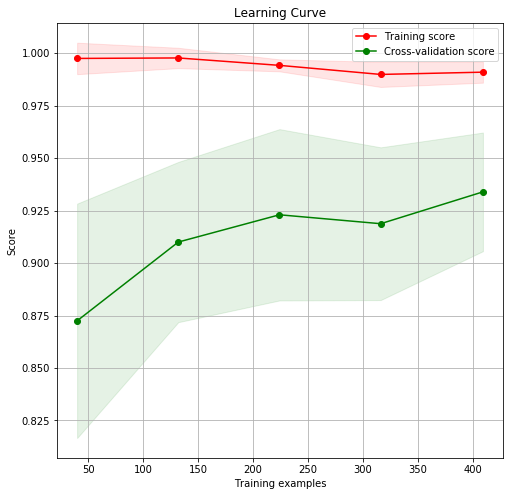

In [35]:
import scikitplot as skplt 
import matplotlib.pyplot as plt 

skplt.estimators.plot_learning_curve(RF,X_train,y_train,cv=10,figsize=(8,8))
plt.show()

上图展示了两条信息：

+ 红线和绿线 - 分别代表训练准确率和验证准确率，随着训练数据的数量的增加，训练准确率减小，验证准确率增大，合理。注：准确率 = 100% - 误差。

+ 红色和绿色透明块 - 分别代表训练准确率和验证准确率的标准差，因为在 10 折交叉验证时，实际上算了 10 次验证准确率，最后取均值得到交叉验证准确率，那么同样我们可以求这 10 个验证准确率的标准差，看看它们是否稳定。从上图而看，训练准确率的标准差小 (红块窄)，而验证准确率的标准差大 (绿块宽)。

## 3.3 特征重要性

Scikit-Plot 中的 plot_feature_importances 函数可以将「特征重要性」排序并画出。

先看一个「特征重要性」的知识点。

### 特征重要性
随机森林有个特有的机制可以排序特征从而选择重要性最高的。整个核心思想就是:

**如果特征 j 是重要特征，那么加入一些随机噪声模型性能会下降。**

具体做法是把所有数据在特征 j 上的值重新随机排列，整个过程的专业叫法是置换检验 (permutation test)。这样做的好处是可以保证随机打乱 (干扰) 的数据分布和原数据接近一致。

看个简单例子，下图给出了在特征「性格」上做随机排列后的数据样貌，随机排列将“好坏坏好坏坏好好”排成“坏坏好好好坏坏好”。

<img style = 'float:mid' src = 'images\66.jpg'>

在置换检验后，特征 j 的重要性可看成是森林「在原数据的性能」和「在特征 j 数据置换后的性能」的差距，有

**重要性($j$) = |误差($D$) – 误差($D^p$)|**

其中 $D$ 是原有采样数据，$D^p$ 是置换之后的数据。

接着上面的随机森林分类器 RF，用训练集 (X_train, y_train) 拟合它。

In [36]:
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
                       oob_score=False, random_state=1031, verbose=0,
                       warm_start=False)

函数 plot_feature_importances 用到的参数有 4 个：

+ RF：随机森林分类器
+ feature_names：特征名称，本例有 30 个
+ x_tick_rotation：横轴刻度旋转度，本例设置 90 度，因为特征多，名字长，不旋转 90 度图中显示非常乱
+ figsize：图片大小


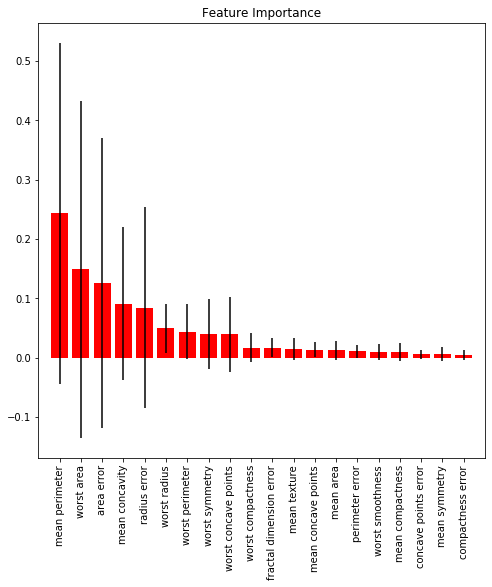

In [37]:
skplt.estimators.plot_feature_importances(RF,feature_names=breast_cancer['feature_names'],x_tick_rotation=90,figsize=(8,8))

plt.show()

上图展示了两条信息：

+ 红色条形 - 表示重要性。按着其大小排序，发现 mean perimeter, worst area 和 area error 是「决定是否有乳腺癌」的前三重要特征。

+ 黑色实线 - 表示特征重要性的标准差。本例中随机森林是由 5 棵决策树组成，在每棵树上都可以计算出一组特征重要性，因此也可以在 5 棵树上计算特征重要性的标准差。